In [11]:
# import off-the-shelf libraries
import os
import imp
import sys
import GPy, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time as timemodule
import copy

print '%s\t\t %s' % ('pandas',pd.__version__)
print '%s\t\t %s' % ('numpy', np.__version__)
print '%s\t\t %s' % ('scipy', scipy.__version__)
print '%s\t\t %s' % ('GPy', GPy.__version__)
print '%s\t\t %s' % ('seaborn', sns.__version__)
print '%s\t %s' % ('matplotlib', mpl.__version__)

# set global parameters
%matplotlib inline
sns.set_style('white')

pandas		 0.22.0
numpy		 1.10.2
scipy		 1.0.0
GPy		 1.9.6
seaborn		 0.8.0
matplotlib	 2.1.1


In [12]:
sys.path.append("..")
from libs import classical,growth,plates

In [1]:
# import off-the-shelf libraries
import os
import imp
import sys
import GPy, scipy
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import time as timemodule
import copy

print '%s\t\t %s' % ('pandas',pd.__version__)
print '%s\t\t %s' % ('numpy', np.__version__)
print '%s\t\t %s' % ('scipy', scipy.__version__)
print '%s\t\t %s' % ('GPy', GPy.__version__)
print '%s\t\t %s' % ('seaborn', sns.__version__)
print '%s\t %s' % ('matplotlib', mpl.__version__)

# set global parameters
%matplotlib inline
sns.set_style('white')

# import in-house libraries
lib_path = '/Users/firasmidani/Downloads/phenotypic-characterization/'
lib_path = 
lib_path_0 = lib_path + 'growth_models/growth.py'
lib_path_1 = lib_path + 'plate_reader_library.py'
lib_path_2 = lib_path + 'growth_fitting_library.py'

foo0 = imp.load_source('growth_models',lib_path_0);
foo1 = imp.load_source('plate_reader_library',lib_path_1);
foo2 = imp.load_source('growth_fitting_library',lib_path_2)

from growth_models import *
from plate_reader_library import *
from growth_fitting_library import *

pandas		 0.22.0
numpy		 1.10.2
scipy		 1.0.0
GPy		 1.9.6
seaborn		 0.8.0
matplotlib	 2.1.1


***WARNING*** ```BiopythonExperimentalWarning```
<br></br></br> 
```Bio.phenotype``` is an experimental submodule which may undergo significant changes prior to its future official release.

# Read Data

In [298]:
data = pd.read_csv('../data/Magellan/PRB954_PM1-1.tsv',sep='\t',header=0,index_col=0);
data.head()

,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [299]:
# format 
print type(data.columns[0])

# convert headers from strings to integers
data.columns = listTimePoints(interval=600,numTimePoints=data.shape[1])

data.index.name = 'Well'
data.T.index.name = 'Time'

print type(data.columns[0])

data.head()

<type 'str'>
<type 'numpy.int64'>


Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


# Read Meta-data

In [300]:
key = populatePlateKey('PRB954_PM1-1');
key.head()

,Isolate,Substrate,Plate
Well,,,
A1,PRB954,Negative Control,PRB954_PM1-1
A2,PRB954,L-Arabanose,PRB954_PM1-1
A3,PRB954,N-Acetyl-D-Glucosamine,PRB954_PM1-1
A4,PRB954,D-Saccharic Acid,PRB954_PM1-1
A5,PRB954,Succinic Acid,PRB954_PM1-1


In [301]:
# remove time points with NaN from data
data = data.iloc[:,np.where(~data.isna().all(0))[0]]
data.head()

Time,0,600,1200,1800,2400,3000,3600,4200,4800,5400,...,54000,54600,55200,55800,56400,57000,57600,58200,58800,59400
Well,,,,,,,,,,,,,,,,,,,,,
A1,0.277,0.275,0.279,0.280,0.289,0.296,0.310,0.328,0.351,0.362,...,0.478,0.473,0.476,0.477,0.474,0.476,0.471,0.474,0.476,0.474
B1,0.282,0.275,0.280,0.281,0.289,0.301,0.312,0.324,0.341,0.355,...,0.487,0.480,0.481,0.485,0.488,0.489,0.479,0.481,0.486,0.478
C1,0.279,0.276,0.278,0.282,0.289,0.297,0.309,0.325,0.339,0.360,...,0.481,0.477,0.478,0.480,0.481,0.482,0.477,0.475,0.479,0.478
D1,0.267,0.266,0.271,0.274,0.282,0.293,0.302,0.321,0.338,0.349,...,0.422,0.424,0.421,0.421,0.422,0.422,0.421,0.418,0.418,0.416
E1,0.279,0.273,0.279,0.278,0.286,0.295,0.309,0.318,0.335,0.364,...,0.487,0.483,0.486,0.492,0.486,0.489,0.487,0.487,0.489,0.491


In [302]:
# initialize pd.DataFrame for summarizing data sets

order_columns = ['Letter','Plate','Row','Column']
order_columns += ['Isolate','Substrate','Max OD','Growth Fold']
order_columns

summary = summarizeGrowthData(data)
summary = summary.join(key)
summary = summary.loc[:,order_columns]

summary.head()

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold
Well,,,,,,,,
A1,A,PRB954_PM1-1,1,1,PRB954,Negative Control,0.214362,1.000000
B1,B,PRB954_PM1-1,2,1,PRB954,D-Serine,0.212137,0.989620
C1,C,PRB954_PM1-1,3,1,PRB954,D-Glucose-6-Phospate,0.216576,1.010329
D1,D,PRB954_PM1-1,4,1,PRB954,L-Asparagine,0.189050,0.881920
E1,E,PRB954_PM1-1,5,1,PRB954,L-Glutamine,0.211803,0.988062


In [303]:
# prepare data for growth dynamics inference
data = data.T
data = data.loc[:,key.index]
data = data.reset_index(drop=False);
data.head()

Well,Time,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,600,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,1200,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,1800,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,2400,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


# Create GrowthPlate object and describe

In [304]:
# define plate object and prepare it for analysis
plate = GrowthPlate(data=data,key=summary,control='A1');

In [305]:
plate.time.head()

,Time
0,0
1,600
2,1200
3,1800
4,2400


In [306]:
plate.data.head()

Well,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,H3,H4,H5,H6,H7,H8,H9,H10,H11,H12
0,0.277,0.282,0.275,0.270,0.269,0.265,0.257,0.248,0.271,0.265,...,0.268,0.266,0.263,0.253,0.253,0.246,0.259,0.259,0.258,0.268
1,0.275,0.281,0.283,0.269,0.268,0.263,0.254,0.244,0.267,0.260,...,0.279,0.279,0.278,0.270,0.263,0.256,0.268,0.262,0.261,0.270
2,0.279,0.286,0.276,0.272,0.273,0.268,0.260,0.248,0.271,0.265,...,0.274,0.274,0.277,0.262,0.259,0.256,0.266,0.263,0.261,0.271
3,0.280,0.287,0.288,0.272,0.275,0.269,0.263,0.252,0.275,0.270,...,0.271,0.273,0.281,0.260,0.258,0.260,0.266,0.265,0.260,0.271
4,0.289,0.294,0.305,0.279,0.284,0.277,0.268,0.256,0.279,0.273,...,0.283,0.286,0.304,0.271,0.269,0.272,0.276,0.272,0.265,0.277


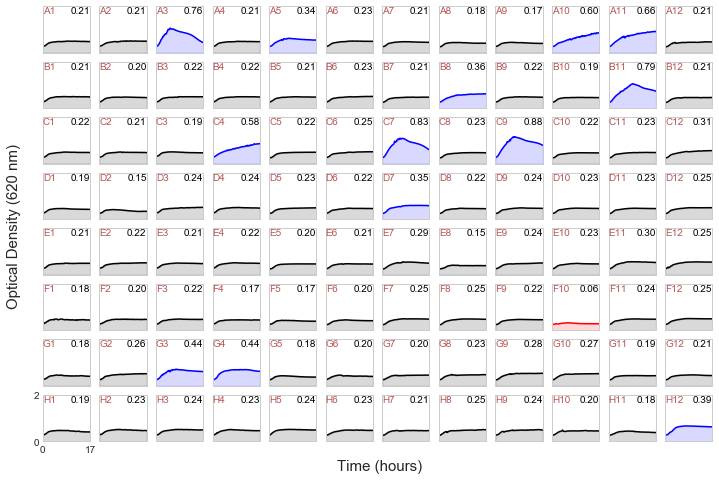

In [307]:
fig,ax = plate.plot();
fig

# Create GrowthData object and describe

In [308]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

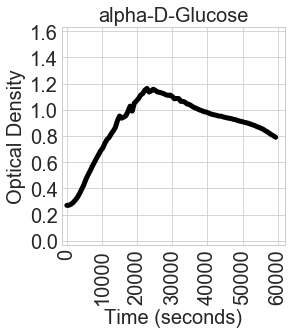

In [309]:
fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-1500,62000])

[ii.set(rotation=90) for ii in ax.get_xticklabels()];

ax.set_xlabel('Time (seconds)');

In [310]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

## Conver Time to minutes

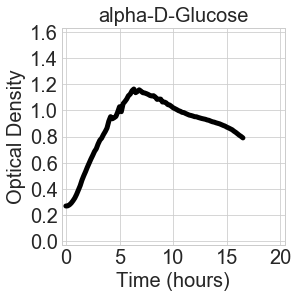

In [311]:
plate.convertTimeUnits()

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot()

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [312]:
plate.mods

smoothed      False
floored       False
controlled    False
logged        False
dtype: bool

## Smooth OD data

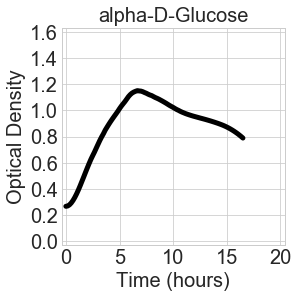

In [313]:
plate.smoothData();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [314]:
plate.mods

smoothed       True
floored       False
controlled    False
logged        False
dtype: bool

## Transform with natural logarithm

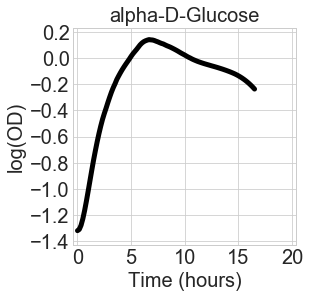

In [315]:
plate.logData();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-1.43,0.23])
ax.set_xlim([-0.4,20.4])

ax.set_xlabel('Time (hours)');

In [316]:
plate.mods

smoothed       True
floored       False
controlled    False
logged         True
dtype: bool

## Scale OD to the first time point log(OD)=0 <--> OD=1

(-0.4, 20.4)

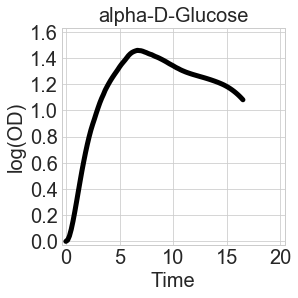

In [317]:
plate.subtractBaseline();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

In [318]:
plate.mods

smoothed       True
floored        True
controlled    False
logged         True
dtype: bool

## Subtract negative control OD at each time point

(-0.4, 20.4)

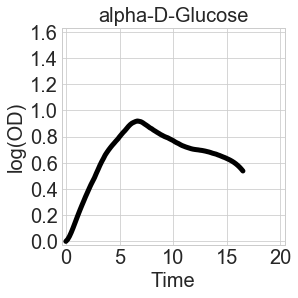

In [319]:
plate.subtractControl();

fig,ax = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']}).plot();

ax.set_ylim([-0.03,1.63])
ax.set_xlim([-0.4,20.4])

In [320]:
plate.mods

smoothed      True
floored       True
controlled    True
logged        True
dtype: bool

In [321]:
foo0 = imp.load_source('growth_models',lib_path_0);
foo1 = imp.load_source('plate_reader_library',lib_path_1);
foo2 = imp.load_source('growth_fitting_library',lib_path_2)

from growth_models import *
from plate_reader_library import *
from growth_fitting_library import *

## Fit growth curves with classical approach of Gompertz

Doubling Rate is 165.38 minutes


,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,classical_r,classical_K,classical_d,classical_AUC,classical_td
Well,,,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.251482,0.768531,0.470357,10.826688,165.375027


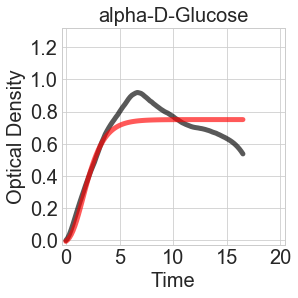

In [322]:
glucose = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']})

classical = GrowthMetrics(glucose);
classical.Classical(logistic)
classical.inferClassicalDynamics()
classical.predictClassical()

fig,ax = classical.plot();

ax.set_ylim([-0.03,1.32])
ax.set_xlim([-0.4,20.4])

print 'Doubling Rate is %0.2f minutes' % classical.key['classical_td']

classical.key

## Fit growth curve with non-parameteric GP Regression approach

Doubling Rate is 190.61 minutes


,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td
Well,,,,,,,,,,,,
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.218193,0.917325,10.871468,190.605635


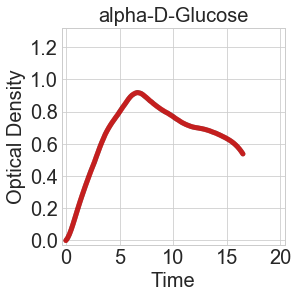

In [323]:
glucose = plate.extractGrowthData({'Substrate':['alpha-D-Glucose']})

gpr = GrowthMetrics(glucose);
gpr.GP()
gpr.inferGPDynamics()
gpr.predictGP()

fig,ax = gpr.plot();

ax.set_ylim([-0.03,1.32])
ax.set_xlim([-0.4,20.4])

print 'Doubling Rate is %0.2f minutes' % gpr.key['GP_td']

gpr.key

# Summarize dynamics in all wells of the plate

In [324]:
# initialize pd.DataFrame to store summary metrics/statistics
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC','GP_td',
                                       'classical_r','classical_K','classical_AUC','classical_td']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [326]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    growth = plate.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    
    classical = GrowthMetrics(growth)
    classical.Classical(gompertz)
    classical.inferClassicalDynamics()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = classical.key.index[0]
    growth_summary.loc[to_index,to_header] = classical.key.loc[to_index,to_header].values

    gpr = GrowthMetrics(growth)
    gpr.GP()
    gpr.inferGPDynamics()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = gpr.key.index[0]
    growth_summary.loc[to_index,to_header] = gpr.key.loc[to_index,to_header].values


01 . . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [327]:
summary_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_df.head(10)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,
A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141,0.285946,0.763807,7.16737,145.443,0.286188,-0.573639,7.17666,145.32
H5,H,PRB954_PM1-1,8,5,PRB954,D-Psicose,0.243431,1.135607,0.284019,0.136797,1.56914,146.43,-0.0331991,0.0396141,1.56319,-1252.71
C7,C,PRB954_PM1-1,3,7,PRB954,D-Fructose,0.825154,3.849344,0.235521,0.899295,10.1327,176.582,NaN,NaN,10.1089,NaN
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.218193,0.917325,10.8715,190.606,0.276124,0.702884,10.8267,150.616
G4,G,PRB954_PM1-1,7,4,PRB954,L-Threonine,0.440850,2.056564,0.172972,0.415119,5.35975,240.436,0.186327,0.412682,5.33326,223.204
H12,H,PRB954_PM1-1,8,12,PRB954,2-Aminoethanol,0.387359,1.807031,0.163044,0.362182,4.45912,255.078,0.197789,0.309303,4.43422,210.269
F10,F,PRB954_PM1-1,6,10,PRB954,Glyoxylic Acid,0.062088,0.289641,0.153532,0.0232271,-5.73861,270.88,NaN,NaN,-5.70294,NaN
B11,B,PRB954_PM1-1,2,11,PRB954,D-Mannitol,0.792709,3.697988,0.153035,0.871126,9.91157,271.761,0.189046,0.693595,9.86597,219.993
G6,G,PRB954_PM1-1,7,6,PRB954,L-Alanyl-Glycine,0.200206,0.933962,0.152304,0.0472129,-0.784114,273.065,NaN,NaN,-0.775738,NaN


# Analyze growth metrics across plate  (example)

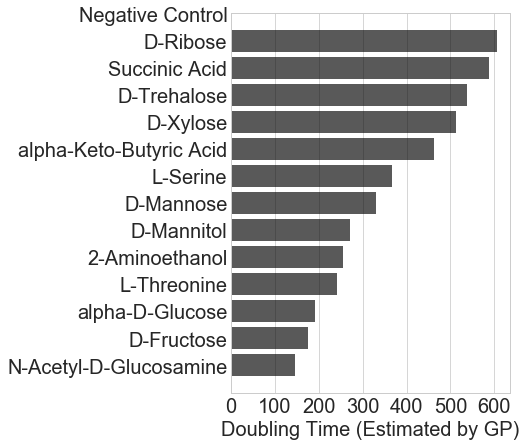

In [328]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_df[summary_df['Growth Fold']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_df[summary_df.isin({'Substrate':subset}).any(1)].Substrate
td = summary_df[summary_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=td,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)

In [329]:
plate.mods

smoothed      True
floored       True
controlled    True
logged        True
dtype: bool

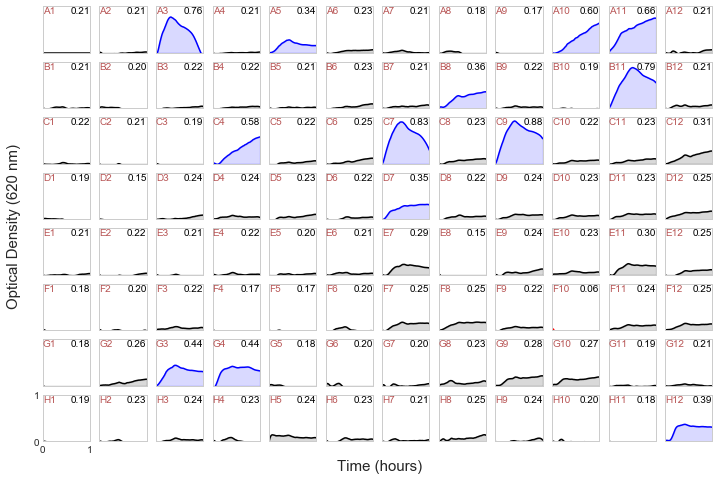

In [331]:
fig,ax = plate.plot();
fig

## Would this be different if you do not subtract negative control (no carbon) growth?

In [335]:
# define plate object and prepare it for analysis
plate = GrowthPlate(data=data,key=summary,control='A1');

In [336]:
plate.convertTimeUnits()
plate.smoothData()
plate.logData()
plate.subtractBaseline()

plate.mods

smoothed       True
floored        True
controlled    False
logged         True
dtype: bool

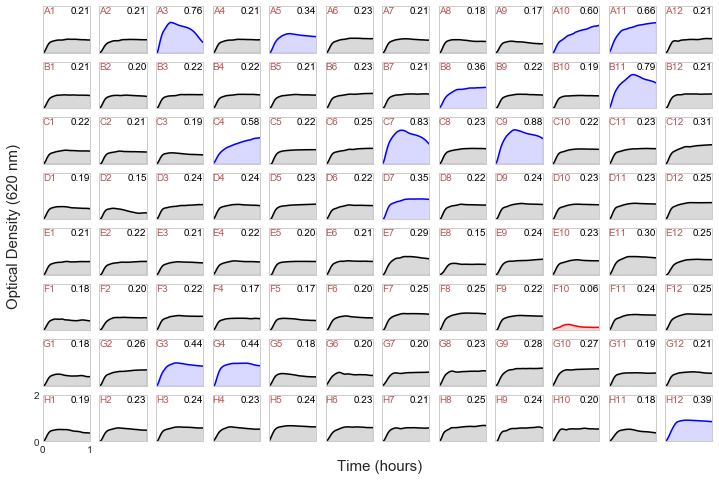

In [338]:
fig,ax = plate.plot(); fig

In [339]:
# initialize pd.DataFrame to store summary metrics/statistics
growth_summary = pd.DataFrame(index=summary.index,
                              columns=['GP_r','GP_K','GP_AUC','GP_td',
                                       'classical_r','classical_K','classical_AUC','classical_td']);
growth_summary.head()

,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,
A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
D1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
E1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
counter = 0;
row_count = 1; print '%02d' % row_count,
for well in growth_summary.index:

    if counter<12:
        print '.',
        counter += 1;
    else:
        row_count += 1;
        print '\n%02d .' % row_count,
        counter = 1;

    substrate = plate.key.loc[well,'Substrate']; #print substrate
    growth = plate.extractGrowthData({'Substrate':[substrate]}); # control is not subtracted
    
    
    classical = GrowthMetrics(growth)
    classical.Classical(gompertz)
    classical.inferClassicalDynamics()

    to_header = ['classical_r','classical_K','classical_AUC','classical_td'];
    to_index = classical.key.index[0]
    growth_summary.loc[to_index,to_header] = classical.key.loc[to_index,to_header].values

    gpr = GrowthMetrics(growth)
    gpr.GP()
    gpr.inferGPDynamics()

    to_header = ['GP_r','GP_K','GP_AUC','GP_td'];
    to_index = gpr.key.index[0]
    growth_summary.loc[to_index,to_header] = gpr.key.loc[to_index,to_header].values

01 . . . . . . . . . . . . 
02 . . . . . . . . . . . . 
03 . . . . . . . . . . . . 
04 . . . . . . . . . . . . 
05 . . . . . . . . . . . . 
06 . . . . . . . . . . . . 
07 . . . . . . . . . . . . 
08 . . . . . . . . . . . .


In [341]:
summary_df = summary.join(growth_summary).sort_values(['GP_td'],ascending=True)
summary_df.head(10)

,Letter,Plate,Row,Column,Isolate,Substrate,Max OD,Growth Fold,GP_r,GP_K,GP_AUC,GP_td,classical_r,classical_K,classical_AUC,classical_td
Well,,,,,,,,,,,,,,,,
A3,A,PRB954_PM1-1,1,3,PRB954,N-Acetyl-D-Glucosamine,0.758015,3.536141,0.551288,1.2994,15.3562,75.4394,NaN,NaN,15.3202,NaN
C7,C,PRB954_PM1-1,3,7,PRB954,D-Fructose,0.825154,3.849344,0.499031,1.44046,18.3216,83.3392,NaN,NaN,18.2524,NaN
C9,C,PRB954_PM1-1,3,9,PRB954,alpha-D-Glucose,0.880712,4.108523,0.481169,1.45736,19.0603,86.4329,0.488181,1.31714,18.9702,85.1915
B11,B,PRB954_PM1-1,2,11,PRB954,D-Mannitol,0.792709,3.697988,0.414369,1.44527,18.1004,100.367,0.357155,1.38926,18.0095,116.445
G4,G,PRB954_PM1-1,7,4,PRB954,L-Threonine,0.440850,2.056564,0.413091,0.970252,13.5486,100.677,0.392533,0.991082,13.4768,105.95
G3,G,PRB954_PM1-1,7,3,PRB954,L-Serine,0.440657,2.055666,0.353448,0.981725,13.238,117.666,0.3398,0.942065,13.1676,122.392
D7,D,PRB954_PM1-1,4,7,PRB954,alpha-Keto-Butyric Acid,0.345211,1.610409,0.34221,0.869727,12.1307,121.53,0.292249,1.39499,12.0597,142.306
A11,A,PRB954_PM1-1,1,11,PRB954,D-Mannose,0.655933,3.059927,0.334585,1.2855,16.2704,124.3,267.706,2537.68,16.1634,0.155353
H8,H,PRB954_PM1-1,8,8,PRB954,Pyruvic Acid,0.251108,1.171419,0.303926,0.679403,9.20334,136.839,74.7748,422.832,9.14753,0.556188


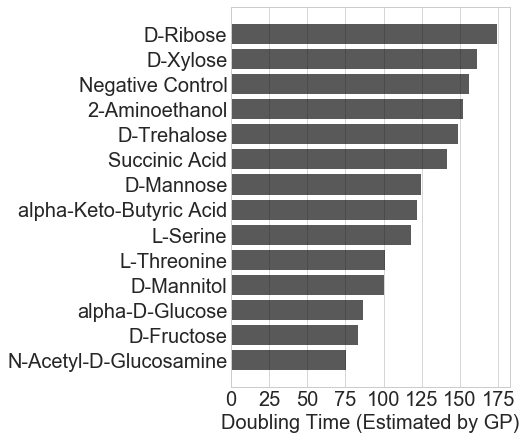

In [342]:
fig,ax = plt.subplots(figsize=[5,7]);

# grab all growth curves with at least 1.5 fold change (relative to negative control)
subset = list(summary_df[summary_df['Growth Fold']>1.5].Substrate.values)+list(['Negative Control']);

labels = summary_df[summary_df.isin({'Substrate':subset}).any(1)].Substrate
td = summary_df[summary_df.isin({'Substrate':subset}).any(1)].GP_td;

ax.barh(y=range(len(labels)),width=td,height=0.8,color=(0,0,0,0.65));

[ii.set(fontsize=20) for ii in ax.get_xticklabels()+ax.get_yticklabels()];

ax.set_xlabel('Doubling Time (Estimated by GP)',fontsize=20);
plt.setp(ax,yticks=range(len(labels)),yticklabels=labels);
ax.yaxis.grid(False)